In [6]:
#28/6/24 CHEMBL drug targets where inserted into STRING (https://string-db.org) selecting only Homo Sapien genes
#Of the 313 drug targets, 219 where mapped
#They where then converted into a graph with targets as edges and an interaction score as vectors
#This notebook aims to insert each drug SMILE into the graph based on the average of its targets
#The distance of each molecule from each drug target can then be used as a feature set to predict on
#Aims:
    #Cluster all vectors on graph by targeted drug
        #Find distances between nodes in cluster
    #Determine how to plot each drug onto the graph
        #Maybe average of its targets
    #Create a useable dataset to predict on
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 20)

#Data import
targetdata = pd.read_csv('/Users/james/Documents/Honours/Data/Targetdata/mutagen/mutDrugTargets.csv')
stringdf = pd.read_csv('/Users/james/Documents/Honours/Data/Targetdata/mutagen/STRING/string_network_coordinates.tsv', sep='\t')
chembltouni = pd.read_csv('/Users/james/Documents/Honours/Data/Targetdata/mutagen/STRING/chembltouniprotmapping.tsv', sep='\t')
stringtouni = pd.read_csv('/Users/james/Documents/Honours/Data/Targetdata/mutagen/STRING/stringtouniprotmapping.tsv', sep='\t')

In [145]:
toxvals = targetdata['Toxicity_Values'].values

In [7]:
#Removes the duplicate id
chembltouni = chembltouni.drop(23)
chembltouni.reset_index(drop=True, inplace=True)

In [9]:
#finds the index of each chembl id from one df to the other
unitochemindex = []
ids = []
loops = 0
for item in stringtouni['Entry']:
    iter = 0
    for thing in chembltouni['Entry']:
        if item == thing:
            unitochemindex.append(iter)
            ids.append(chembltouni['From'][iter])
        iter += 1
    loops += 1
stringtouni['CHEMBL'] = ids

In [14]:
#Creates 1 dataframe containing, chemblid and its coordinates on the STRING graph
loops = 0
index = []
ids = []
for item in stringtouni['From']:
    iter = 0
    for thing in stringdf['identifier']:
        if item == thing:
            index.append(iter)
            ids.append(stringtouni['CHEMBL'][iter])
        iter += 1
    loops += 1
stringdf['CHEMBL'] = ids
stringdf = stringdf.drop('#node', axis=1)
stringdf = stringdf.drop('identifier', axis=1)
stringdf = stringdf.drop('color', axis=1)

In [103]:
stringdf

,x_position,y_position,CHEMBL
0,0.400735,0.344747,CHEMBL3004
1,0.344786,0.533268,CHEMBL220
2,0.522861,0.806420,CHEMBL3589
3,0.398329,0.765564,CHEMBL226
4,0.368249,0.779572,CHEMBL255
...,...,...,...
214,0.380882,0.642412,CHEMBL4794
215,0.845922,0.575875,CHEMBL2157850
216,0.827874,0.689105,CHEMBL1075317
217,0.388102,0.457393,CHEMBL1929


In [132]:
#creates a list of each coordinate in [x,y] form
temp = [stringdf['x_position'].values, stringdf['y_position'].values]
pointlist = []
loops = 0
for item in temp[0]:
    pointlist.append([temp[0][loops], temp[1][loops]])
    loops = loops + 1

In [133]:
pointlist

[[0.4007352941176471, 0.3447470817120622],
 [0.3447860962566845, 0.5332684824902724],
 [0.5228609625668449, 0.806420233],
 [0.3983288770053476, 0.7655642023346304],
 [0.3682486631016043, 0.7795719844357978],
 [0.3917112299465241, 0.8105058365758755],
 [0.1793449197860962, 0.6196498054474708],
 [0.3032754010695187, 0.5974708171206226],
 [0.4067513368983957, 0.7013618677042802],
 [0.4446524064171123, 0.6459143968871596],
 [0.4602941176470588, 0.8011673151750973],
 [0.3267379679144385, 0.6190661478599222],
 [0.572192513, 0.6307393],
 [0.6708556149732621, 0.6085603112840468],
 [0.5228609625668449, 0.2070038910505836],
 [0.2912433155080214, 0.2904669260700389],
 [0.1835561497326203, 0.5536964980544747],
 [0.4272058823529411, 0.5017509727626459],
 [0.842312834, 0.457976653696498],
 [0.7129679144385027, 0.5303501945525292],
 [0.2593582887700535, 0.5414396887159533],
 [0.4031417112299465, 0.4550583657587548],
 [0.2918449197860963, 0.4678988326848249],
 [0.5523395721925134, 0.4684824902723735],

In [32]:
#Cleans column names from targetdata by removing accessory characters
new = []
for col in targetdata.columns:
    new_col = col.replace('(', '').replace(')', '').replace("'", '').replace(',', '')
    new.append(new_col)
targetdata.columns = new

In [37]:
cleandat = targetdata.drop('SMILES', axis=1)
cleandat = cleandat.drop('Toxicity_Values', axis=1)

In [62]:
#Creates a list of each SMILES and their drug targets based on targetdata
colnames = cleandat.columns
loops = 0
hitlist = []
for row in cleandat.values:
    iter = 0
    hits = []
    for col in row:
        if col == 1:
            hits.append(iter)
        iter += 1
    hitlist.append(hits)
    loops += 1
            

In [71]:
#Create a list that corresponds each smile to their target ids
idlist = []
for chembls in hitlist:
    templist = []
    for index in chembls:
        templist.append(colnames[index])
    idlist.append(templist)


In [77]:
#Converts coordinates to an (x,y) tuple retaining index
stringdf.values
coordlist = []

for sublist in stringdf.values:
    tuple_from_first_two = tuple(sublist[:2])
    coordlist.append(tuple_from_first_two)

In [93]:
#Links each smile to the index of the coords of their drug targets
coordindex = []
for drug in idlist:
    druglist = []
    for target in drug:
        loops = 0
        for chembl in stringdf['CHEMBL']:
            if chembl == target:
                index = loops
            loops += 1
        druglist.append(index)
    coordindex.append(druglist)

In [95]:
len(coordindex)

7485

In [109]:
#Converts the drug target list back into its coordinate tuple
smilescoords = []
for chembl in coordindex:
    templist = []
    for index in chembl:
        templist.append(coordlist[index])
    
    smilescoords.append(templist)

In [175]:
#creates a list of average distances for each smile
avelist = []
for smile in smilescoords:
    ydist = 0
    xdist = 0
    coordcount = len(smile)
    for coord in smile:
        xdist += coord[0]
        ydist += coord[1]
    
    ydist = ydist / coordcount
    xdist = xdist  / coordcount
    
    avelist.append([xdist, ydist])
    

In [186]:
import statistics
avelist = []
for smile in smilescoords:
    xlist = []
    ylist = []
    for coord in smile:
        xlist.append(coord[0])
        ylist.append(coord[1])
    
    xdist = statistics.median(xlist)
    ydist = statistics.median(ylist)
    avelist.append([xdist, ydist])

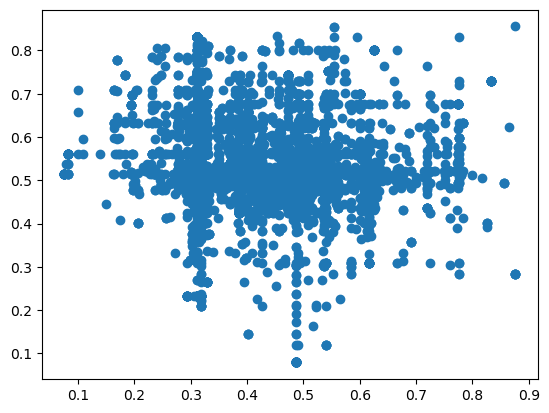

In [188]:
import matplotlib.pyplot as plt
xcoords = [x[0] for x in avelist]
ycoords = [y[1] for y in avelist]

plt.scatter(xcoords, ycoords)

In [189]:
#creates a list containing the distance from each smile each point is
#for clarity, pointdists is a list corresponding to GO point
#each GO point then contains a list of the distance from each smile to it
import math
pointdists = []
for point in avelist:
    distlist = []
    for smile in pointlist:
        xdist = smile[0] + point[0]
        ydist = smile[1] + point[1]
        
        netdist = math.sqrt(xdist*xdist + ydist*ydist)
        distlist.append(netdist)
        
    pointdists.append(distlist)

pointframe = pd.DataFrame(pointdists)

In [190]:
pointframe

,0,1,2,3,4,5,6,7,8,9,...,209,210,211,212,213,214,215,216,217,218
0,1.190984,1.298948,1.624570,1.520558,1.516347,1.554995,1.283408,1.327839,1.471812,1.448955,...,0.951166,1.354700,1.701912,1.067751,1.297999,1.408633,1.674211,1.736777,1.266195,1.586995
1,1.366839,1.491418,1.817337,1.719498,1.717664,1.755958,1.491368,1.526412,1.667661,1.639716,...,1.135050,1.532482,1.860191,1.223066,1.451104,1.603691,1.832966,1.904096,1.450928,1.769764
2,1.170139,1.294080,1.619965,1.522633,1.521144,1.559363,1.296588,1.329584,1.470494,1.442307,...,0.937659,1.335669,1.667153,1.029914,1.258924,1.406480,1.639788,1.709086,1.253578,1.572593
3,1.184080,1.291215,1.616768,1.512480,1.508157,1.546817,1.274929,1.319807,1.463887,1.441275,...,0.943967,1.347655,1.695690,1.061889,1.292133,1.400756,1.667973,1.730134,1.258842,1.579666
4,1.110672,1.229215,1.555278,1.455908,1.453671,1.492031,1.226868,1.262800,1.404707,1.378135,...,0.875133,1.275701,1.613954,0.977490,1.207389,1.340891,1.586420,1.652843,1.191210,1.511134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7480,1.223127,1.318434,1.642226,1.533524,1.527223,1.566028,1.289015,1.342081,1.487627,1.468958,...,0.980024,1.384496,1.741801,1.112999,1.342653,1.425412,1.713946,1.771373,1.291737,1.612237
7481,1.374883,1.514207,1.838022,1.747557,1.748462,1.786107,1.531803,1.555461,1.692638,1.659506,...,1.153743,1.540531,1.848577,1.215728,1.438900,1.628283,1.821935,1.899881,1.466345,1.780627
7482,1.178377,1.273004,1.596764,1.488086,1.481828,1.520631,1.243799,1.296622,1.442162,1.423530,...,0.935087,1.339523,1.697752,1.069957,1.299398,1.379948,1.669883,1.726736,1.246519,1.566969
7483,1.106012,1.225335,1.551385,1.452368,1.450275,1.488609,1.223958,1.259262,1.400995,1.374151,...,0.870858,1.271116,1.608649,0.972067,1.201908,1.337140,1.581130,1.647845,1.186943,1.506758


In [191]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
model= rf.fit(pointdists[:6000], toxvals[:6000])

In [192]:
import os
import pandas as pd
import numpy as np
import math
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sys
sys.path.insert(1, '/Users/james/Documents/Honours/Python')
from Function_Repo import metriccalc

preds = model.predict(pointdists[6000:])
print(metriccalc(preds, toxvals[6000:])[12])

-0.043616538632721004
